## Small Forex environment preliminary RL experiments

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(""), os.pardir)))

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from datetime import datetime, timedelta
from tensorboard import notebook
from sb3_contrib import RecurrentPPO
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from rl_trading.environments import (
    Actions,
    ForexEnvBasic,
    ForexMarketOrderStrategyAllIn,
    ForexRewardStrategyLogPortfolioReturn,
    ForexTradingCostsStrategySpread,
    
)
from rl_trading.data.forex import (
    FOREX_PAIRS,
    ForexDataSource,
    ForexFeEngStrategy,
    load_processed_forex_data,
    engineer_forex_features
)
from rl_trading.utils import TextProgressBarCallback
from config import DATA_PATH, LOGS_PATH

In [3]:
TARGET = 'EURUSD'

In [4]:
TRN_START_DATE = datetime(2003,1,2,1,0,0)
TRN_END_DATE = TRN_START_DATE + timedelta(hours=250)

In [5]:
ENV_LENGTH = 1000
N_EPISODES = 500
N_STEPS = (ENV_LENGTH - 1) * N_EPISODES

In [6]:
ENV_KWARGS = dict(
    portfolio_value=1000,
    market_order_strategy=ForexMarketOrderStrategyAllIn(),
    reward_strategy=ForexRewardStrategyLogPortfolioReturn(),
    trading_costs_strategy=ForexTradingCostsStrategySpread(spread=0.0001),
    include_in_obs = ['position']
)

In [7]:
TB_LOGS_PATH = f'{LOGS_PATH}/small env training/TensorBoard/ForexSmallEURUSD'

In [8]:
forex_data = load_processed_forex_data(DATA_PATH, ForexDataSource.FOREXTESTER, pairs=FOREX_PAIRS, version='Agg')

In [9]:
target_prices = forex_data[TARGET]
target_prices = target_prices[
    (target_prices['<DT>'] >= TRN_START_DATE) & (target_prices['<DT>'] < TRN_END_DATE)
].reset_index(drop=True)

In [10]:
target_prices

,<DT>,<OPEN>,<HIGH>,<LOW>,<CLOSE>
0,2003-01-02 01:00:00,1.0481,1.0492,1.0481,1.0492
1,2003-01-02 01:15:00,1.0492,1.0493,1.0490,1.0490
2,2003-01-02 01:30:00,1.0490,1.0490,1.0487,1.0487
3,2003-01-02 01:45:00,1.0486,1.0486,1.0483,1.0484
4,2003-01-02 02:00:00,1.0484,1.0484,1.0474,1.0475
...,...,...,...,...,...
995,2003-01-12 09:45:00,1.0576,1.0576,1.0576,1.0576
996,2003-01-12 10:00:00,1.0576,1.0576,1.0576,1.0576
997,2003-01-12 10:15:00,1.0576,1.0576,1.0576,1.0576
998,2003-01-12 10:30:00,1.0576,1.0576,1.0576,1.0576


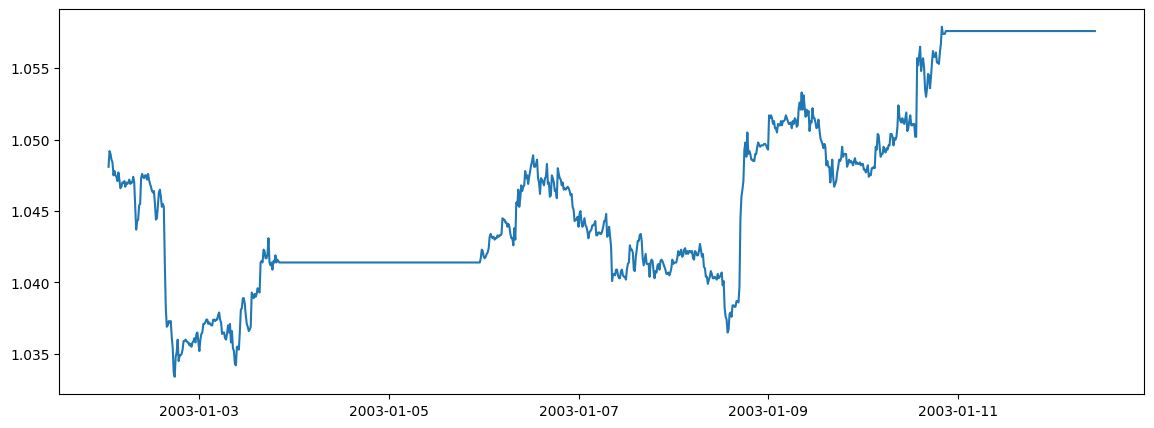

In [11]:
plt.figure(figsize=(14,5))
plt.plot(target_prices['<DT>'], target_prices['<OPEN>'])

In [12]:
features = engineer_forex_features(forex_data, ForexFeEngStrategy.STRATEGY1, {'recent_returns' : 8})
features_no_lag = engineer_forex_features(forex_data, ForexFeEngStrategy.STRATEGY1, {'recent_returns' : 1})
target_features = engineer_forex_features({TARGET: forex_data[TARGET]}, ForexFeEngStrategy.STRATEGY1, {'recent_returns' : 8})

In [13]:
features = features[
    (features['<DT>'] >= TRN_START_DATE) & (features['<DT>'] < TRN_END_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

features_no_lag = features_no_lag[
    (features_no_lag['<DT>'] >= TRN_START_DATE) & (features_no_lag['<DT>'] < TRN_END_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

target_features = target_features[
    (target_features['<DT>'] >= TRN_START_DATE) & (target_features['<DT>'] < TRN_END_DATE)
].drop('<DT>', axis=1).reset_index(drop=True)

In [14]:
features

,<MIN SIN>,<HOUR SIN>,<WEEKDAY SIN>,<AUDJPY OPEN RECENT RETURN 1>,<AUDJPY OPEN RECENT RETURN 2>,<AUDJPY OPEN RECENT RETURN 3>,<AUDJPY OPEN RECENT RETURN 4>,<AUDJPY OPEN RECENT RETURN 5>,<AUDJPY OPEN RECENT RETURN 6>,<AUDJPY OPEN RECENT RETURN 7>,...,<USDCHF OPEN RECENT RETURN 7>,<USDCHF OPEN RECENT RETURN 8>,<USDJPY OPEN RECENT RETURN 1>,<USDJPY OPEN RECENT RETURN 2>,<USDJPY OPEN RECENT RETURN 3>,<USDJPY OPEN RECENT RETURN 4>,<USDJPY OPEN RECENT RETURN 5>,<USDJPY OPEN RECENT RETURN 6>,<USDJPY OPEN RECENT RETURN 7>,<USDJPY OPEN RECENT RETURN 8>
0,0.000000e+00,0.258819,0.433884,0.000300,0.000000,-0.000150,-0.000600,0.00000,0.00045,-0.00015,...,0.000433,-0.002020,0.000506,0.000000,0.000084,-0.000842,-0.000168,0.000253,0.000084,0.002023
1,1.000000e+00,0.258819,0.433884,0.000749,0.000300,0.000000,-0.000150,-0.00060,0.00000,0.00045,...,-0.000144,0.000433,0.000084,0.000506,0.000000,0.000084,-0.000842,-0.000168,0.000253,0.000084
2,5.665539e-16,0.258819,0.433884,0.000749,0.000749,0.000300,0.000000,-0.00015,-0.00060,0.00000,...,0.000289,-0.000144,0.000253,0.000084,0.000506,0.000000,0.000084,-0.000842,-0.000168,0.000253
3,-1.000000e+00,0.258819,0.433884,0.000598,0.000749,0.000749,0.000300,0.00000,-0.00015,-0.00060,...,-0.000289,0.000289,0.000337,0.000253,0.000084,0.000506,0.000000,0.000084,-0.000842,-0.000168
4,0.000000e+00,0.500000,0.433884,0.000748,0.000598,0.000749,0.000749,0.00030,0.00000,-0.00015,...,-0.000289,-0.000289,0.000084,0.000337,0.000253,0.000084,0.000506,0.000000,0.000084,-0.000842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.000000e+00,0.707107,-0.781832,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
996,0.000000e+00,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
997,1.000000e+00,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,5.665539e-16,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
features_no_lag

,<MIN SIN>,<HOUR SIN>,<WEEKDAY SIN>,<AUDJPY OPEN RECENT RETURN 1>,<AUDUSD OPEN RECENT RETURN 1>,<CHFJPY OPEN RECENT RETURN 1>,<EURCAD OPEN RECENT RETURN 1>,<EURCHF OPEN RECENT RETURN 1>,<EURGBP OPEN RECENT RETURN 1>,<EURJPY OPEN RECENT RETURN 1>,<EURUSD OPEN RECENT RETURN 1>,<GBPCHF OPEN RECENT RETURN 1>,<GBPJPY OPEN RECENT RETURN 1>,<GBPUSD OPEN RECENT RETURN 1>,<NZDJPY OPEN RECENT RETURN 1>,<NZDUSD OPEN RECENT RETURN 1>,<USDCAD OPEN RECENT RETURN 1>,<USDCHF OPEN RECENT RETURN 1>,<USDJPY OPEN RECENT RETURN 1>
0,0.000000e+00,0.258819,0.433884,0.000300,-0.000534,0.000233,-0.000242,0.000000,-0.000307,0.000241,-0.000191,0.000404,0.000733,0.000186,0.000482,0.000000,-0.000064,0.000361,0.000506
1,1.000000e+00,0.258819,0.433884,0.000749,0.000712,0.000583,0.001030,0.000482,0.000307,0.001124,0.001049,0.000045,0.000733,0.000621,0.000161,0.000000,0.000064,-0.000650,0.000084
2,5.665539e-16,0.258819,0.433884,0.000749,0.000534,0.000233,-0.000182,-0.000207,-0.000153,-0.000080,-0.000191,0.000090,0.000314,0.000124,0.000161,0.000000,0.000064,0.000000,0.000253
3,-1.000000e+00,0.258819,0.433884,0.000598,0.000356,0.000117,-0.000242,-0.000138,-0.000307,0.000080,-0.000381,0.000000,0.000052,-0.000186,-0.000321,-0.000573,0.000000,0.000217,0.000337
4,0.000000e+00,0.500000,0.433884,0.000748,0.000711,0.000000,-0.000121,-0.000207,0.000154,-0.000241,-0.000191,-0.000224,-0.000157,-0.000311,0.000000,-0.000764,0.000190,0.000000,0.000084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.000000e+00,0.707107,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
996,0.000000e+00,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
997,1.000000e+00,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,5.665539e-16,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
target_features

,<MIN SIN>,<HOUR SIN>,<WEEKDAY SIN>,<EURUSD OPEN RECENT RETURN 1>,<EURUSD OPEN RECENT RETURN 2>,<EURUSD OPEN RECENT RETURN 3>,<EURUSD OPEN RECENT RETURN 4>,<EURUSD OPEN RECENT RETURN 5>,<EURUSD OPEN RECENT RETURN 6>,<EURUSD OPEN RECENT RETURN 7>,<EURUSD OPEN RECENT RETURN 8>
0,0.000000e+00,0.258819,0.433884,-0.000191,0.000477,0.000382,0.000191,-0.000287,0.000000,-0.000477,0.000668
1,1.000000e+00,0.258819,0.433884,0.001049,-0.000191,0.000477,0.000382,0.000191,-0.000287,0.000000,-0.000477
2,5.665539e-16,0.258819,0.433884,-0.000191,0.001049,-0.000191,0.000477,0.000382,0.000191,-0.000287,0.000000
3,-1.000000e+00,0.258819,0.433884,-0.000381,-0.000191,0.001049,-0.000191,0.000477,0.000382,0.000191,-0.000287
4,0.000000e+00,0.500000,0.433884,-0.000191,-0.000381,-0.000191,0.001049,-0.000191,0.000477,0.000382,0.000191
...,...,...,...,...,...,...,...,...,...,...,...
995,-1.000000e+00,0.707107,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
996,0.000000e+00,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
997,1.000000e+00,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,5.665539e-16,0.500000,-0.781832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
def create_eurusd_small_env(target_prices, features, actions, normalize):
    env = make_vec_env(
        ForexEnvBasic,
        env_kwargs=dict(
            target_prices_df=target_prices,
            features_df=features,
            allowed_actions=actions,
            **deepcopy(ENV_KWARGS)
        )
    )
    if normalize:
        env = VecNormalize(env, norm_reward=False)
    return env

In [18]:
eurusd_small = create_eurusd_small_env(
    target_prices, 
    features, 
    {Actions.SELL, Actions.CLOSE, Actions.BUY}, 
    normalize=False
)

eurusd_small_target_features = create_eurusd_small_env(
    target_prices, 
    target_features, 
    {Actions.SELL, Actions.CLOSE, Actions.BUY}, 
    normalize=False
)

eurusd_small_2_actions = create_eurusd_small_env(
    target_prices, 
    features, 
    {Actions.SELL, Actions.BUY}, 
    normalize=False
)

eurusd_small_2_actions_run_norm = create_eurusd_small_env(
    target_prices, 
    features, 
    {Actions.SELL, Actions.BUY}, 
    normalize=True
)

eurusd_small_2_actions_no_lag = create_eurusd_small_env(
    target_prices, 
    features_no_lag, 
    {Actions.SELL, Actions.BUY}, 
    normalize=False
)

eurusd_small_2_actions_no_lag_run_norm = create_eurusd_small_env(
    target_prices, 
    features_no_lag, 
    {Actions.SELL, Actions.BUY}, 
    normalize=True
)

In [19]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir {TB_LOGS_PATH}

### DQN

In [21]:
dqn_1 = DQN('MlpPolicy', eurusd_small, tensorboard_log=TB_LOGS_PATH)

In [22]:
dqn_1.learn(N_STEPS, tb_log_name='DQN', callback=TextProgressBarCallback())

100%|███████████████████████████████████████| 499500/499500 [02:25<00:00, 3432.10it/s]


In [23]:
obs = eurusd_small.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = dqn_1.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small.step(action)

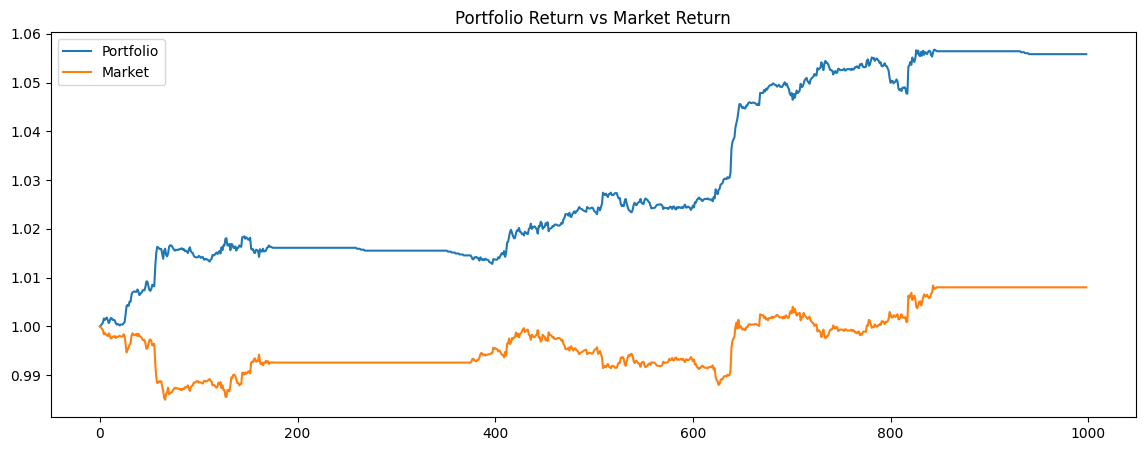

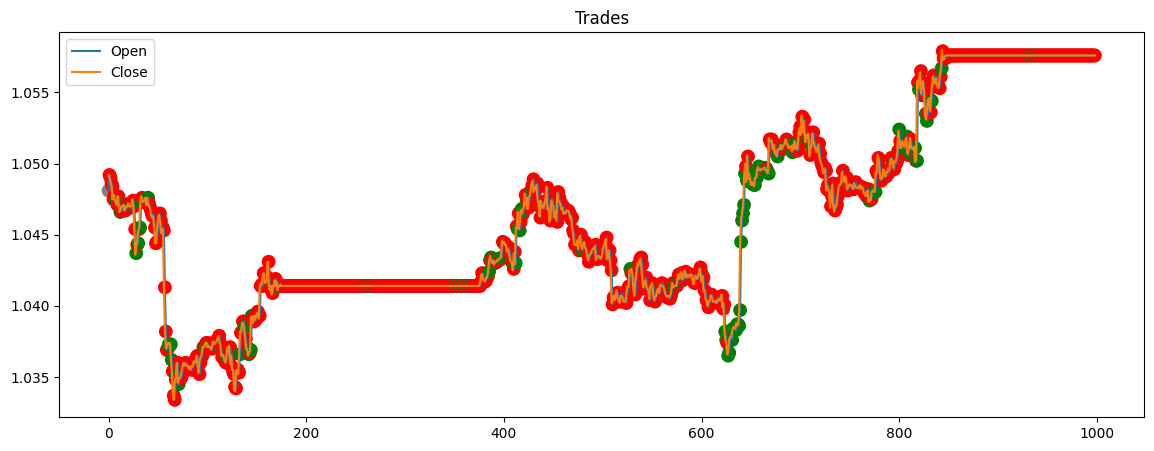

In [24]:
eurusd_small.render()

### DQN, target features only

In [25]:
dqn_2 = DQN('MlpPolicy', eurusd_small_target_features, tensorboard_log=TB_LOGS_PATH)

In [27]:
dqn_2.learn(N_STEPS, tb_log_name='DQN_lim_features', callback=TextProgressBarCallback())

100%|███████████████████████████████████████| 499500/499500 [02:06<00:00, 3954.34it/s]


In [28]:
obs = eurusd_small_target_features.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = dqn_2.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small_target_features.step(action)

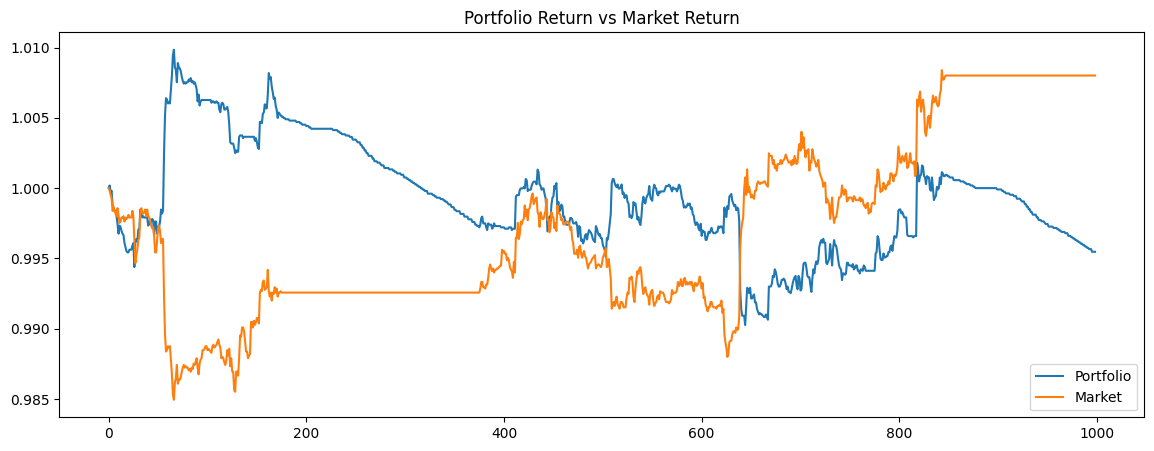

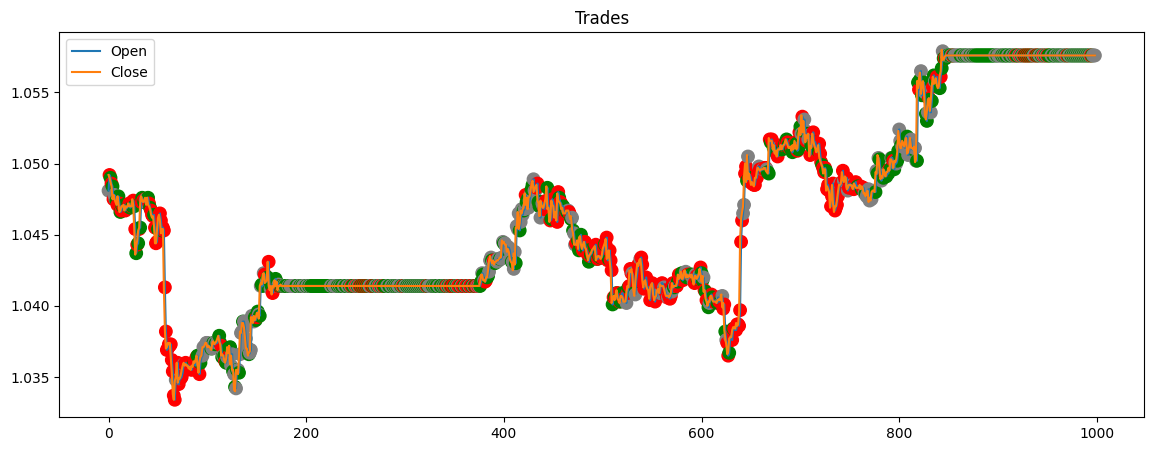

In [29]:
eurusd_small_target_features.render()

### DQN, buy and sell only

In [30]:
dqn_3 = DQN('MlpPolicy', eurusd_small_2_actions, tensorboard_log=TB_LOGS_PATH)

In [31]:
dqn_3.learn(N_STEPS, tb_log_name='DQN_2actions', callback=TextProgressBarCallback())

100%|███████████████████████████████████████| 499500/499500 [02:12<00:00, 3757.18it/s]


In [32]:
obs = eurusd_small_2_actions.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = dqn_3.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small_2_actions.step(action)

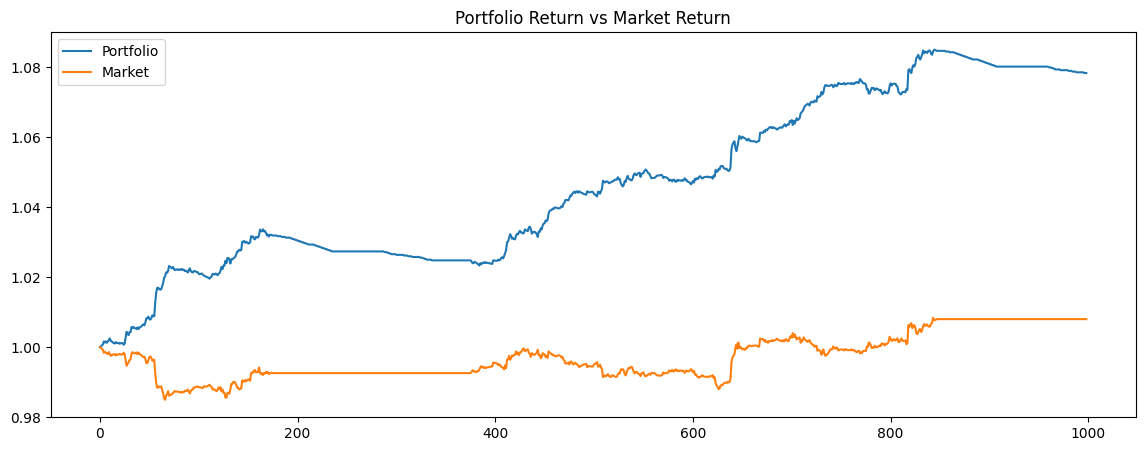

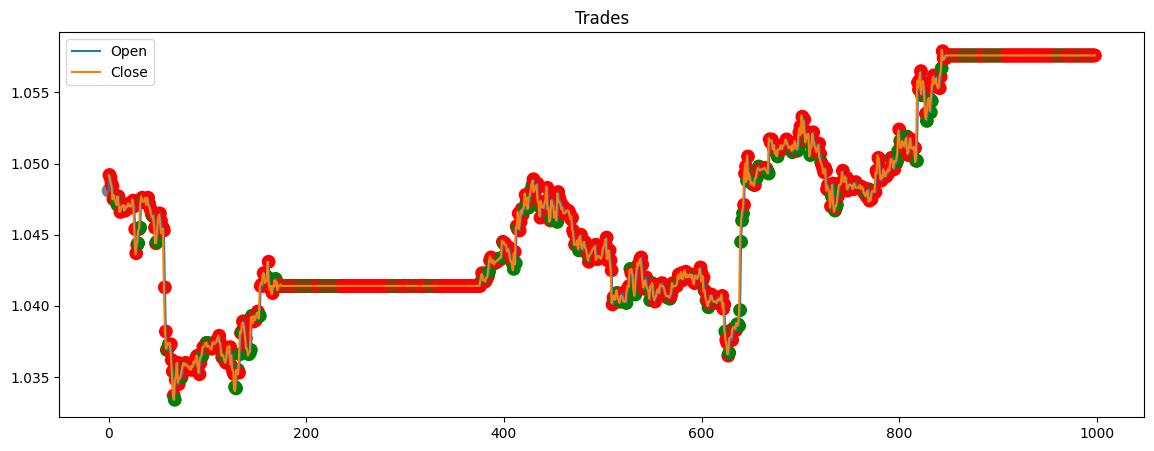

In [33]:
eurusd_small_2_actions.render()

### DQN, buy and sell only, running normalization

In [34]:
dqn_4 = DQN('MlpPolicy', eurusd_small_2_actions_run_norm, tensorboard_log=TB_LOGS_PATH)

In [35]:
dqn_4.learn(N_STEPS, tb_log_name='DQN_2actions_run_norm', callback=TextProgressBarCallback())

100%|███████████████████████████████████████| 499500/499500 [02:57<00:00, 2816.21it/s]


In [36]:
obs = eurusd_small_2_actions_run_norm.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = dqn_4.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small_2_actions_run_norm.step(action)

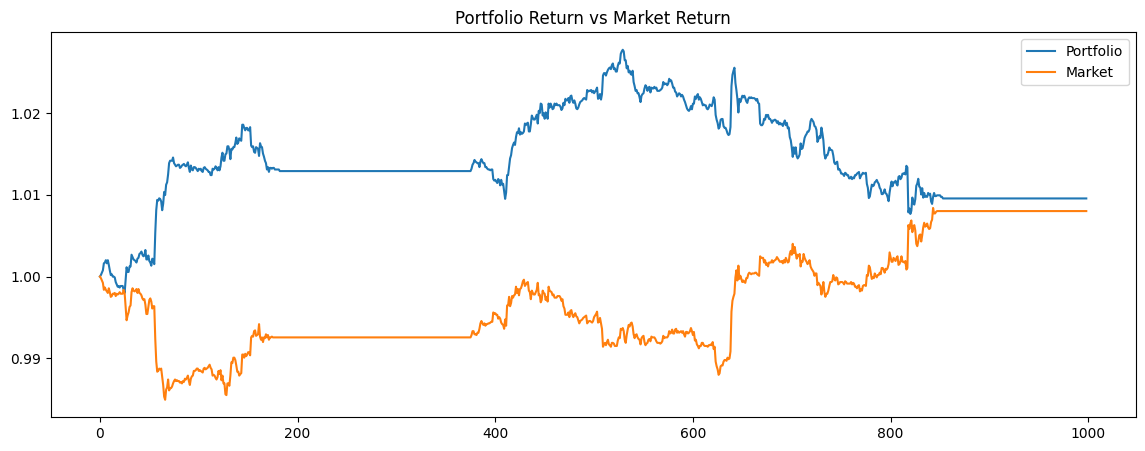

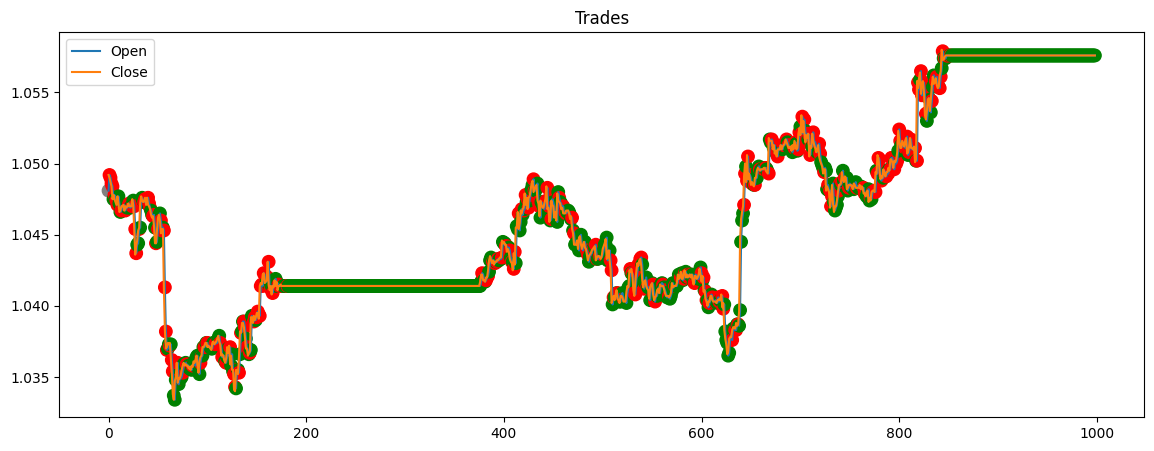

In [37]:
eurusd_small_2_actions_run_norm.render()

### A2C, buy and sell only

In [38]:
a2c_1 = A2C('MlpPolicy', eurusd_small_2_actions, tensorboard_log=TB_LOGS_PATH)

In [39]:
a2c_1.learn(N_STEPS, tb_log_name='A2C_2actions', callback=TextProgressBarCallback()) 

100%|███████████████████████████████████████| 499500/499500 [03:09<00:00, 2635.45it/s]


In [40]:
obs = eurusd_small_2_actions.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = a2c_1.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small_2_actions.step(action)

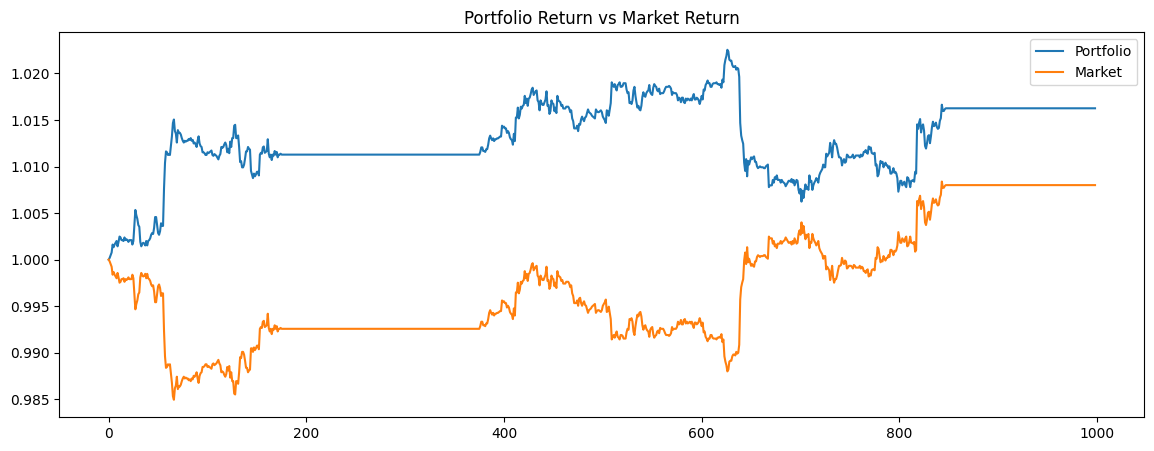

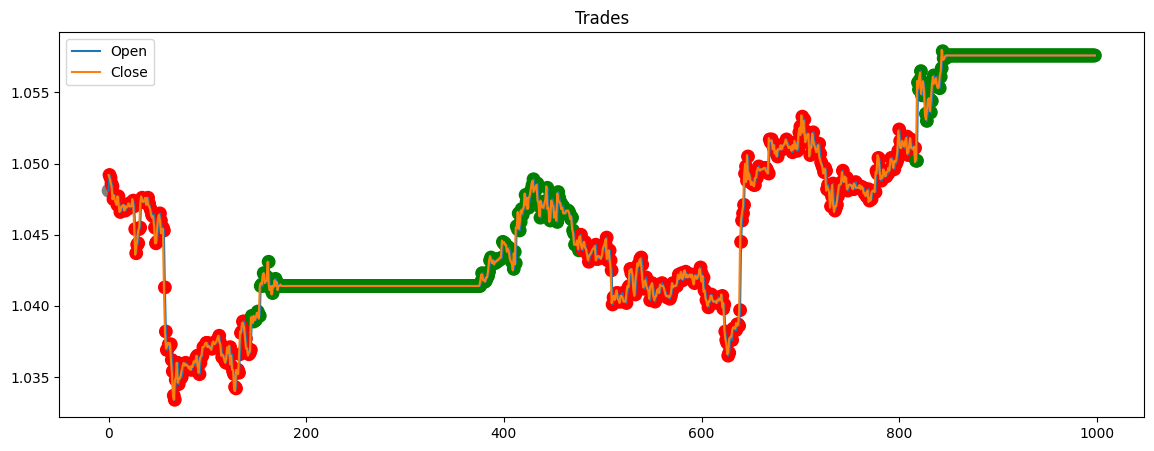

In [41]:
eurusd_small_2_actions.render()

### A2C, buy and sell only, running normalization

In [42]:
a2c_2 = A2C('MlpPolicy', eurusd_small_2_actions_run_norm, tensorboard_log=TB_LOGS_PATH)

In [43]:
a2c_2.learn(N_STEPS, tb_log_name='A2C_2actions_run_norm', callback=TextProgressBarCallback()) 

100%|███████████████████████████████████████| 499500/499500 [03:53<00:00, 2137.04it/s]


In [44]:
obs = eurusd_small_2_actions_run_norm.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = a2c_2.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small_2_actions_run_norm.step(action)

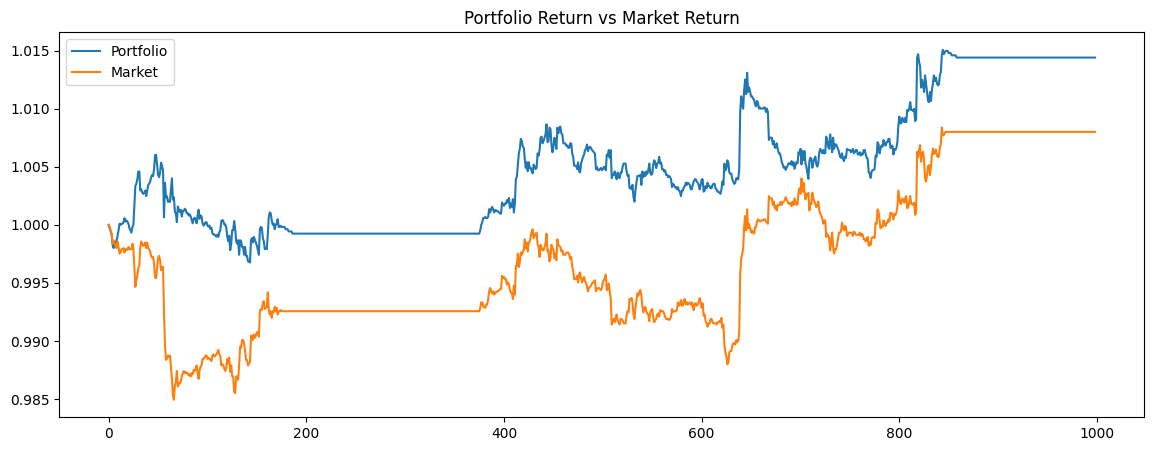

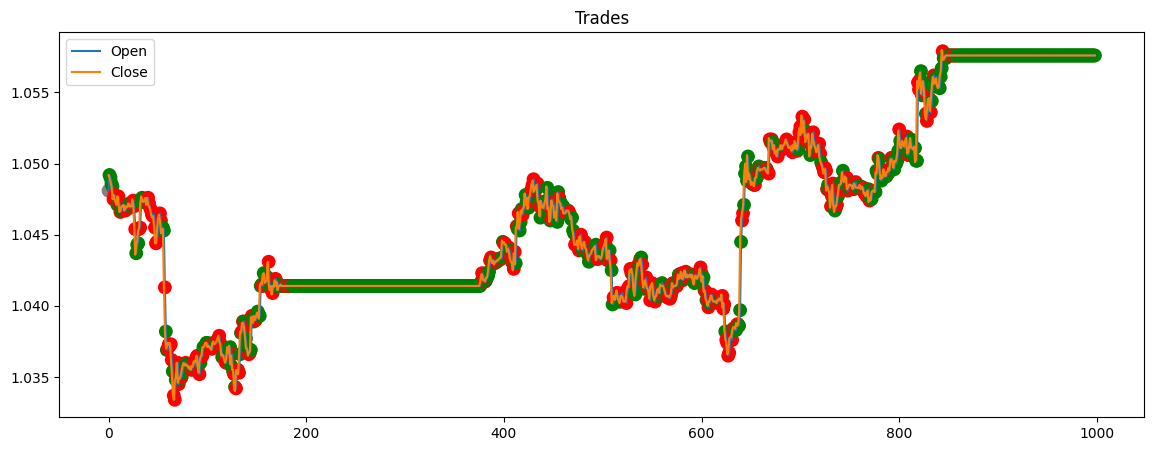

In [45]:
eurusd_small_2_actions_run_norm.render()

### PPO, buy and sell only

In [46]:
ppo_1 = PPO('MlpPolicy', eurusd_small_2_actions, tensorboard_log=TB_LOGS_PATH)

In [47]:
ppo_1.learn(N_STEPS, tb_log_name='PPO_2actions', callback=TextProgressBarCallback()) 

499712it [02:54, 2860.89it/s]                                                         


In [48]:
obs = eurusd_small_2_actions.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = ppo_1.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small_2_actions.step(action)

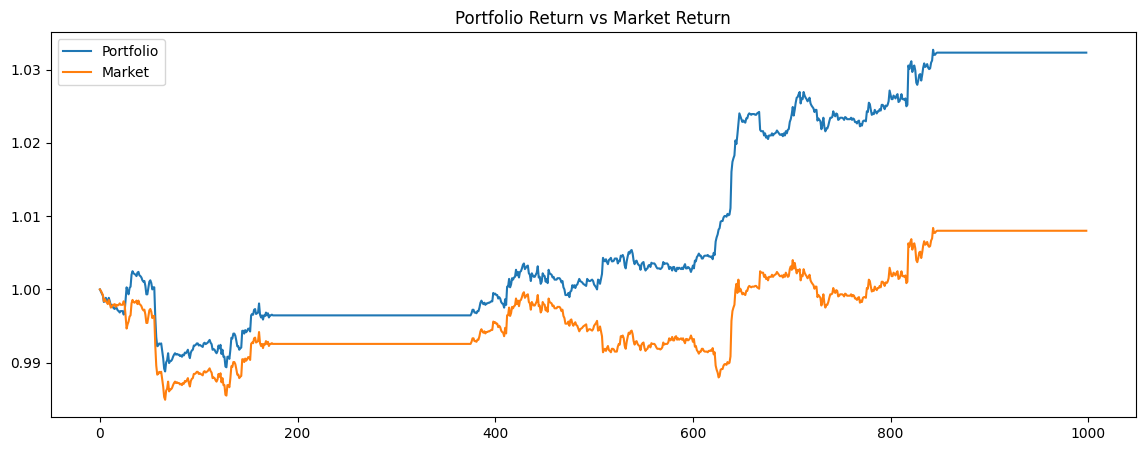

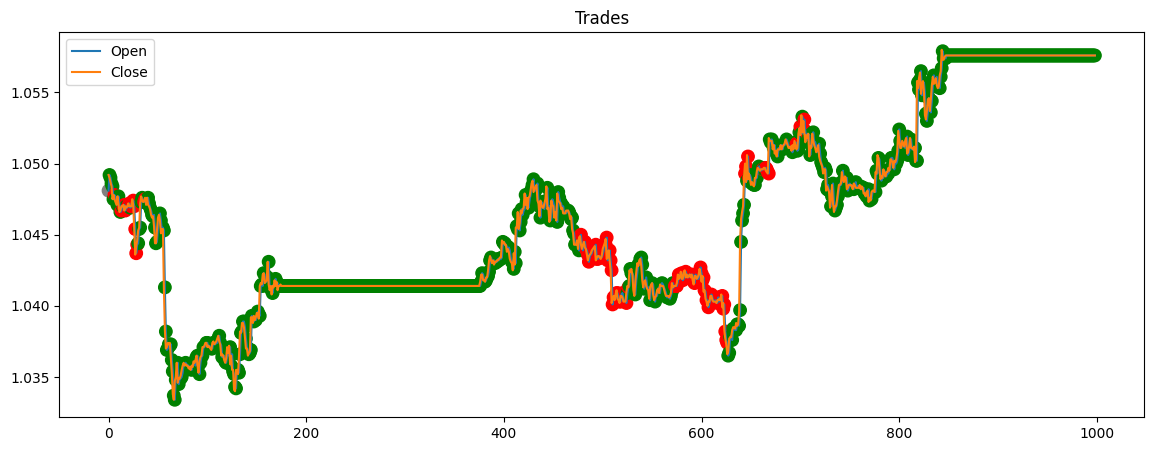

In [49]:
eurusd_small_2_actions.render()

### PPO, buy and sell only, running normalization

In [50]:
ppo_2 = PPO('MlpPolicy', eurusd_small_2_actions_run_norm, tensorboard_log=TB_LOGS_PATH)

In [51]:
ppo_2.learn(N_STEPS, tb_log_name='PPO_2actions_run_norm', callback=TextProgressBarCallback()) 

499712it [03:26, 2420.58it/s]                                                         


In [52]:
obs = eurusd_small_2_actions_run_norm.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = ppo_2.predict(obs, deterministic=True)
    obs, rewards, dones, info = eurusd_small_2_actions_run_norm.step(action)

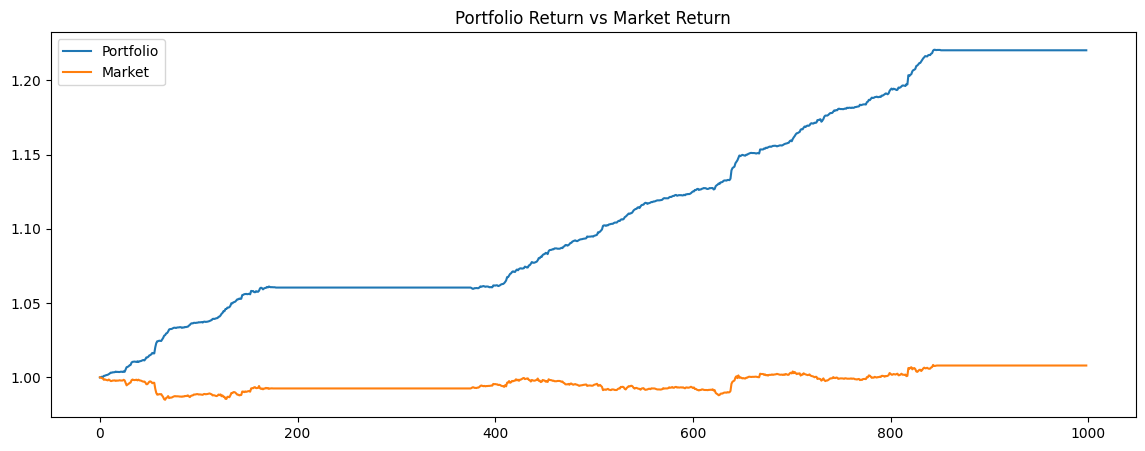

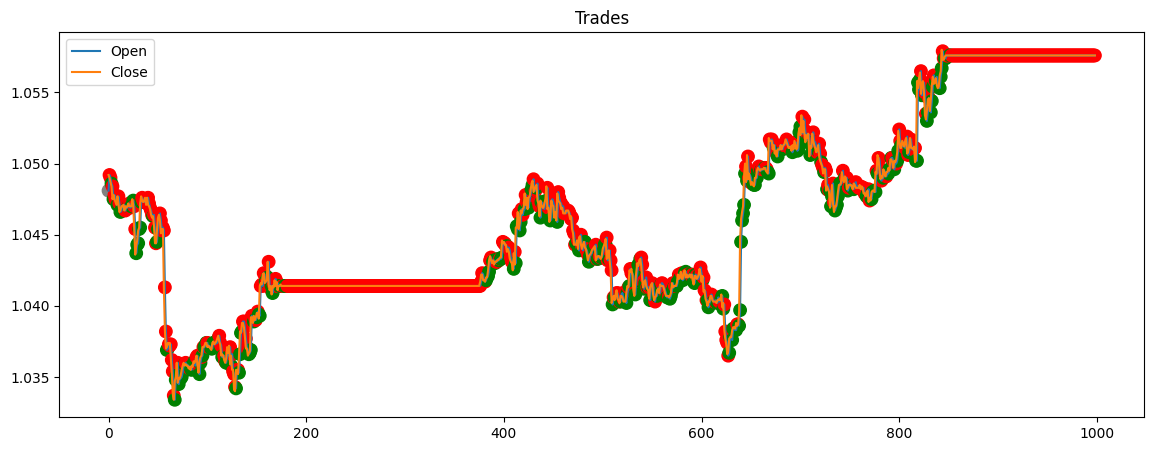

In [53]:
eurusd_small_2_actions_run_norm.render()

### Recurrent PPO, buy and sell only, running normalization

In [54]:
rec_ppo_1 = RecurrentPPO('MlpLstmPolicy', eurusd_small_2_actions_no_lag_run_norm, tensorboard_log=TB_LOGS_PATH)

In [55]:
rec_ppo_1.learn(N_STEPS, tb_log_name='RecPPO_2actions_no_lag_run_norm', callback=TextProgressBarCallback())

499584it [40:05, 207.65it/s]                                                          


In [56]:
obs = eurusd_small_2_actions_no_lag_run_norm.reset()
for i in range((ENV_LENGTH - 2)):
    action, state = rec_ppo_1.predict(obs, state, deterministic=True)
    obs, rewards, dones, info = eurusd_small_2_actions_no_lag_run_norm.step(action)

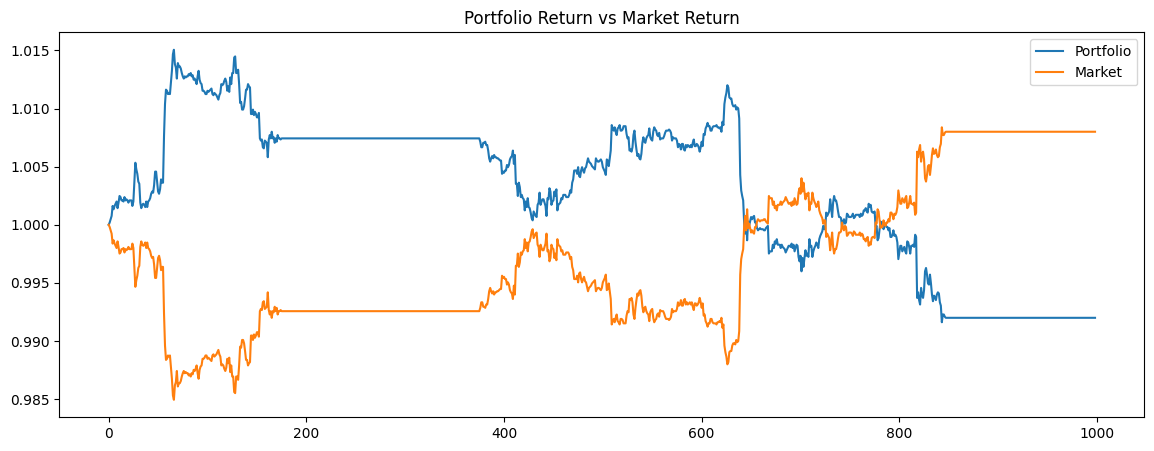

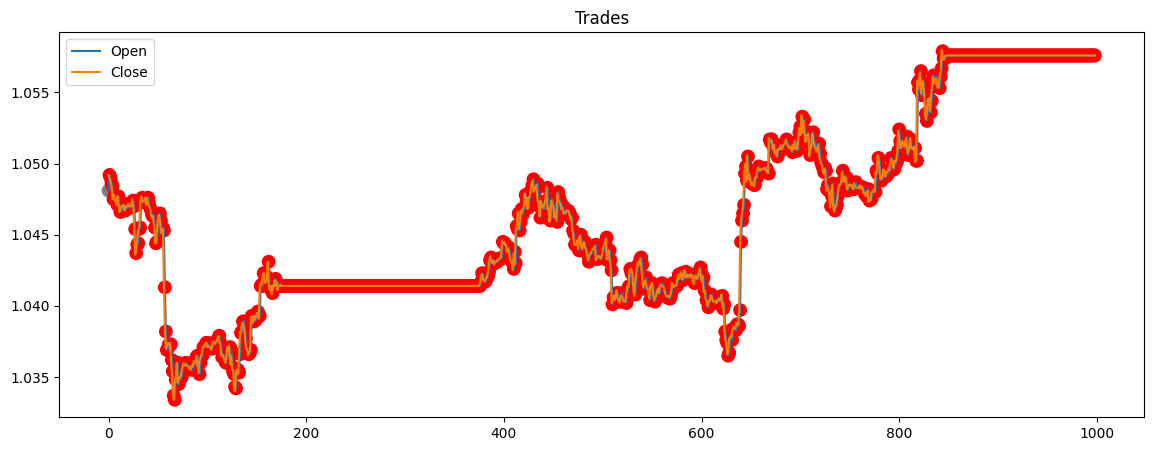

In [57]:
eurusd_small_2_actions_no_lag_run_norm.render()